In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
    
import sys  
sys.path.insert(0, '../src/')
from jsm_massfunc import CSMF, cumulative, CSMF_old, H2H_CSMF
from jsm_datareduc import prep_data
import galhalo
import anaclass


### reading in the accreation masses and redshifts for the surviving halos

In [3]:
massmat = anaclass.MassMat("../../data/12_4_0/acc_surv_mass.npy")

massmat.prep_data()

In [4]:
scatter_pix = 20
scatter_range = np.round(np.linspace(0,2,scatter_pix), 3)
N_samples=500
N_iter=1000 # this will stop us from running into the memory issue

In [5]:
lgMh = massmat.lgMh[0:N_iter]
lgMs = massmat.lgMs[0:N_iter]

In [6]:
mat = np.zeros(shape=(scatter_pix, lgMh.shape[0], N_samples, lgMh.shape[1]))

for i, dex in enumerate(scatter_range):
    mat[i] = galhalo.lgMs_D22_dex(lgMh, dex, N_samples, both=True) # comes out in log mass

In [7]:
#now lets save it so we dont have to run it again

#np.save("../../data/4D_shortest.npy", mat)
#mat = np.load("../../data/4D_shortest.npy")

In [8]:
new_mat = np.zeros(shape=(scatter_pix,N_samples,3,45))

for k in range(scatter_pix):
    for n in range(N_samples):
  
        new_mat[k,n] = CSMF(mat[k,:,n, :], massmat.mass_bins)

In [9]:
across_samp = np.average(new_mat, axis=1) # now lets look at the values!!

In [10]:
np.save("../../data/test_plot.npy", across_samp)
across_samp = np.load("../../data/test_plot.npy")

### now for the CSMF colored by scatter in the SHMR

In [11]:
norm = mpl.colors.Normalize(vmin=scatter_range.min(), vmax=scatter_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.cividis)

colors = mpl.cm.cividis(np.linspace(0, 1, scatter_pix))

/var/folders/wm/2wnpbn757m34vprj1hp7hwzw0000gn/T/ipykernel_23424/4122223199.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cmap, label="SHMR scatter (dex)")


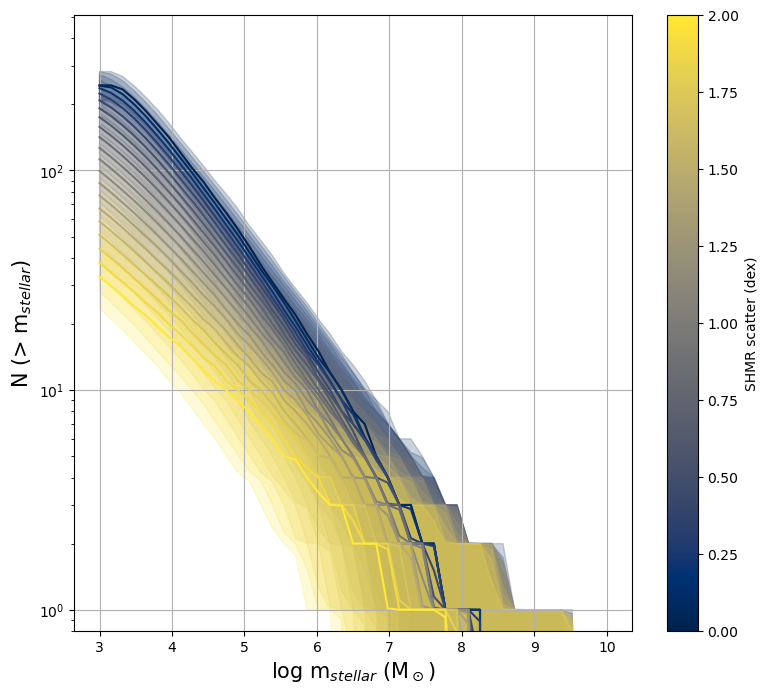

In [12]:
plt.figure(figsize=(9, 8)) # now plotting the color-coded CSMF!!

for i in range(scatter_pix):
    plt.plot(massmat.mass_bins, across_samp[i][1], color=colors[i])
    plt.fill_between(massmat.mass_bins, y1 = across_samp[i][0], y2=across_samp[i][2], color=colors[i], alpha=.2)


plt.yscale("log")
plt.grid()
plt.colorbar(cmap, label="SHMR scatter (dex)")
plt.xlabel("log m$_{stellar}$ (M$_\odot$)", fontsize=15)
plt.ylabel("N (> m$_{stellar}$)", fontsize=15)
plt.ylim(0.8)
plt.show()

### now for the final figures!

In [13]:
mass_range = massmat.mass_bins

CSMF_mat = CSMF(lgMs[0:N_iter], mass_range)

In [14]:
CSMF_mat.shape

(3, 45)

In [15]:
mass_ind = [16,22,28]
masses = np.round(mass_range[mass_ind],1)
colorsx = ["red", "orange", "green"]


In [16]:
mass_range[29]

7.613636363636363

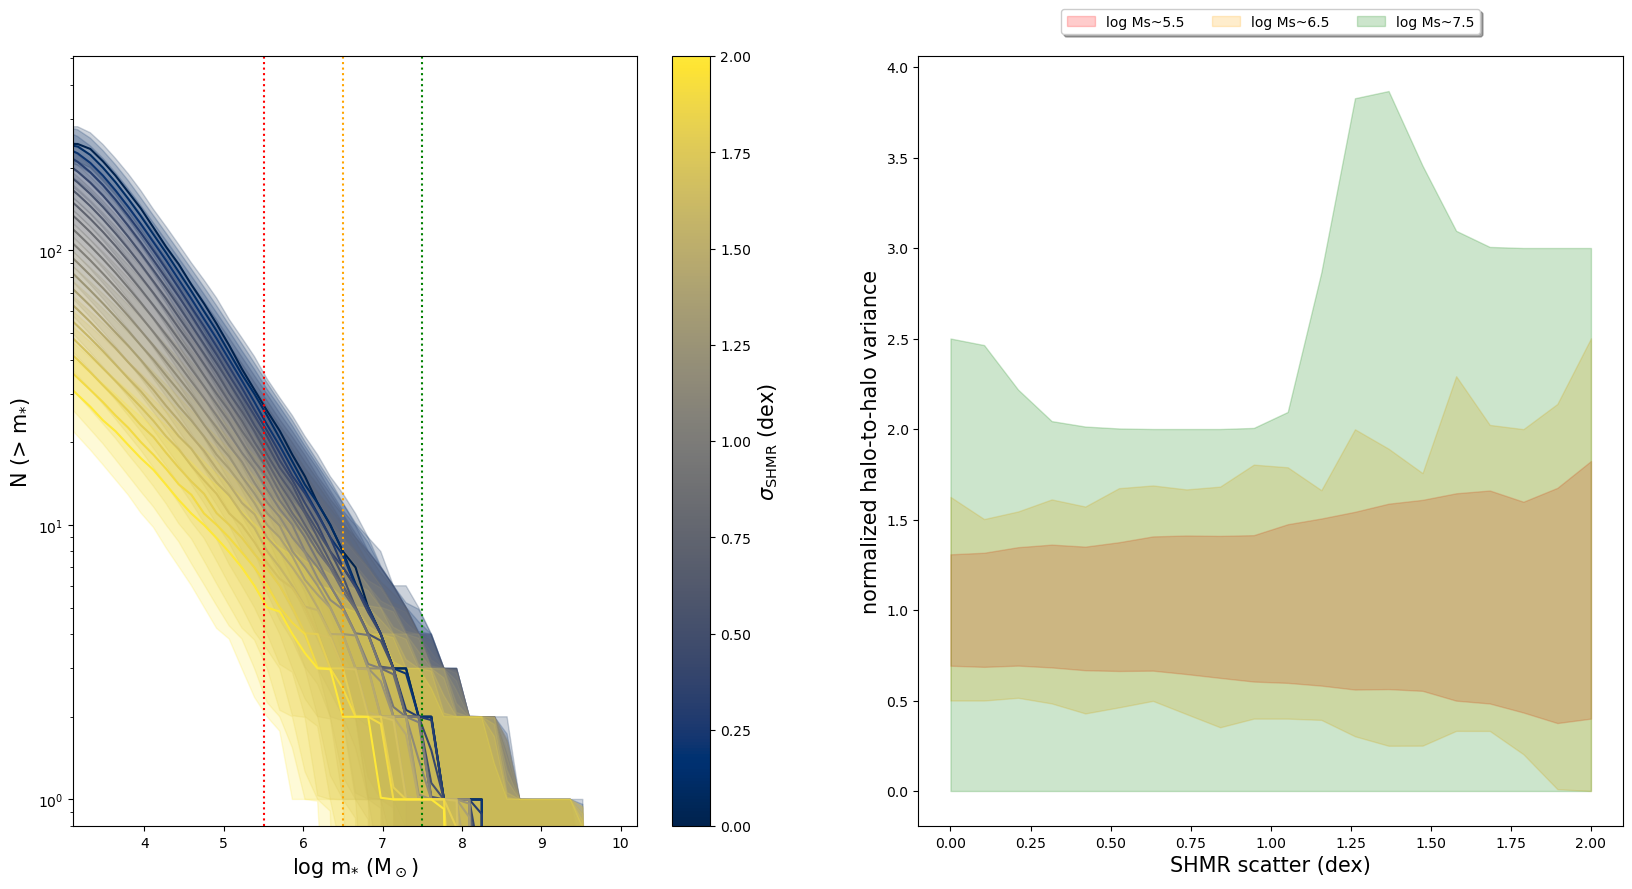

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20,10), sharey=False)

for i in range(scatter_pix):
    axs[0].plot(massmat.mass_bins, across_samp[i][1], color=colors[i])
    axs[0].fill_between(massmat.mass_bins, y1 = across_samp[i][0], y2=across_samp[i][2], color=colors[i], alpha=0.2)

cb = fig.colorbar(cmap, ax=axs[0])
cb.set_label(label='$\sigma_{\mathrm{SHMR}}$ (dex)', fontsize=15)

axs[0].set_xlabel("log m$_{*}$ (M$_\odot$)", fontsize=15)
axs[0].set_ylabel("N (> m$_{*}$)", fontsize=15)
axs[0].set_yscale("log")
axs[0].set_ylim(0.8)
axs[0].set_xlim(3.1,10.2)


for i,val in enumerate(mass_ind):
    axs[1].fill_between(scatter_range, y1 = across_samp[:, 0, val]/across_samp[:, 1, val], y2=across_samp[:, 2, val]/across_samp[:, 1, val], label="log Ms~"+str(masses[i]), color=colorsx[i], alpha=0.2)
    #axs[1].axhspan(CSMF_mat[0, val], CSMF_mat[2, val], 0, 2, label="log Ms~"+str(masses[i]), color=colorsx[i], alpha=0.1)
    #axs[1].axhline(CSMF_mat[0, val], ls=":", color=colorsx[i])
    #axs[1].axhline(CSMF_mat[2, val], ls=":", color=colorsx[i])
    axs[0].axvline(masses[i], color=colorsx[i], ls=":")

axs[1].set_xlabel("SHMR scatter (dex)", fontsize=15)
axs[1].set_ylabel("normalized halo-to-halo variance", fontsize=15)
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.07),
          ncol=5, fancybox=True, shadow=True)
#axs[1].set_yscale("log")
#axs[1].set_ylim(10**0, 10**2.3)

plt.show()